In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
import torchvision
import tqdm

from PIL import Image
import os

import matplotlib.pyplot as plt

from loss import Cross_Entropy_Loss
from model import Residual_CNN

# 데이터셋 구축

In [2]:
train_dogs_lst = [f"dog ({i}).jpg" for i in range(1,4001)]
train_cats_lst = [f"cat ({i}).jpg" for i in range(1,4001)]

valid_dogs_lst = [f"dog ({i}).jpg" for i in range(1,1001)]
valid_cats_lst = [f"cat ({i}).jpg" for i in range(1,1001)]

test_dogs_lst = [f"dog ({i}).jpg" for i in range(1,13)]
test_cats_lst = [f"cat ({i}).jpg" for i in range(1,12)]

In [3]:
test_dogs_lst

['dog (1).jpg',
 'dog (2).jpg',
 'dog (3).jpg',
 'dog (4).jpg',
 'dog (5).jpg',
 'dog (6).jpg',
 'dog (7).jpg',
 'dog (8).jpg',
 'dog (9).jpg',
 'dog (10).jpg',
 'dog (11).jpg',
 'dog (12).jpg']

In [4]:
class CustomDataset(Dataset):
    def __init__(self,files,root,mode='train'):         # files= 이미지 파일명이 저장된 리스트, root = 데이터셋이 있는 디렉터리
        self.files=files
        self.root=root
        self.mode=mode
        self.label=torch.Tensor([0,0])
        self.transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize((224,224)),
            torchvision.transforms.ToTensor(),])

        if "cat" in files[0]:
            self.label[0]=1                                #[cat , dog]
        else:
            self.label[1]=1
    def __len__(self):
        return len(self.files)

    def __getitem__(self,index):
        img = Image.open(os.path.join(self.root, self.files[index]))
        img = self.transform(img)
        if self.mode == 'train':
            return img,np.array(self.label)
        else:
            return img, self.files[index]

In [5]:
train_dogs_dataset=CustomDataset(train_dogs_lst,'dataset/training_set/dogs')
train_cats_dataset=CustomDataset(train_cats_lst,'dataset/training_set/cats')

valid_dogs_dataset=CustomDataset(valid_dogs_lst,'dataset/valid_set/dogs')
valid_cats_dataset=CustomDataset(valid_cats_lst,'dataset/valid_set/cats')

test_dogs_dataset=CustomDataset(test_dogs_lst,'dataset/test_set/dogs')
test_cats_dataset=CustomDataset(test_cats_lst,'dataset/test_set/cats')

In [6]:
train_dataset = ConcatDataset([train_dogs_dataset,train_cats_dataset])
valid_dataset = ConcatDataset([valid_dogs_dataset,valid_cats_dataset])
test_dataset = ConcatDataset([test_dogs_dataset,test_cats_dataset])

In [7]:
print(len(train_dataset),
len(valid_dataset),
len(test_dataset),
)

8000 2000 23


In [8]:
train_dataset[-1]

(tensor([[[0.1647, 0.1647, 0.1647,  ..., 0.2078, 0.2039, 0.2039],
          [0.1765, 0.1765, 0.1725,  ..., 0.2235, 0.2196, 0.2157],
          [0.1922, 0.1882, 0.1843,  ..., 0.2275, 0.2235, 0.2196],
          ...,
          [0.1098, 0.1098, 0.1137,  ..., 0.9882, 0.9922, 0.9922],
          [0.1216, 0.1216, 0.1255,  ..., 0.9882, 0.9922, 0.9922],
          [0.1490, 0.1490, 0.1490,  ..., 0.9843, 0.9882, 0.9882]],
 
         [[0.1216, 0.1216, 0.1216,  ..., 0.0941, 0.0902, 0.0902],
          [0.1255, 0.1255, 0.1255,  ..., 0.1098, 0.1059, 0.1020],
          [0.1294, 0.1294, 0.1294,  ..., 0.1176, 0.1137, 0.1098],
          ...,
          [0.1490, 0.1529, 0.1569,  ..., 0.9725, 0.9725, 0.9725],
          [0.1686, 0.1686, 0.1686,  ..., 0.9686, 0.9725, 0.9725],
          [0.1961, 0.1961, 0.1961,  ..., 0.9647, 0.9686, 0.9686]],
 
         [[0.1059, 0.1059, 0.1059,  ..., 0.1020, 0.0980, 0.0980],
          [0.1098, 0.1098, 0.1059,  ..., 0.1176, 0.1137, 0.1098],
          [0.1059, 0.1059, 0.1020,  ...,

In [9]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=True)

In [10]:
for a,b, in valid_loader:
    print(a.shape)
    print(b.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32, 2])


tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])


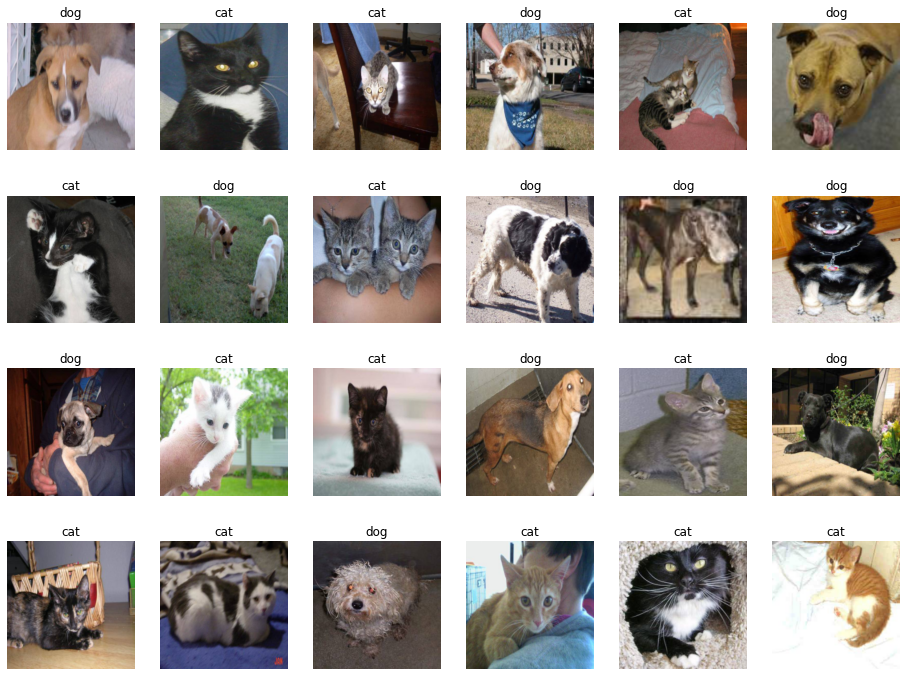

In [11]:
samples, labels = iter(train_loader).next()
print(labels)
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):    
    a = fig.add_subplot(4,6,i+1)    
    a.set_title(classes[np.argmax(labels[i].numpy())])    
    a.axis('off')   
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


# model 선언 및 학습

In [12]:
device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device)+"\n",
device)

NVIDIA GeForce GTX 1050 Ti
 cuda:0


In [13]:
model=Residual_CNN().to(device)

In [14]:
cost = Cross_Entropy_Loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
Epochs=2
train_losses=[]
valid_losses=[]

In [18]:
for epoch in range(Epochs):
    train_loss=0
    for batch,(train_x,train_y) in enumerate(tqdm.tqdm(train_loader)):
        
        model.train()
        train_x=train_x.to(device)
        train_y=train_y.to(device)
        optimizer.zero_grad()

        pred = model(train_x)
        loss = cost(pred, train_y)
        loss.backward()
        optimizer.step()

        train_loss +=loss.item()
    
    valid_loss=0
    for batch,(valid_x,valid_y) in  enumerate(tqdm.tqdm(valid_loader)):
        with torch.no_grad():
            model.eval()
            valid_x=valid_x.to(device)
            valid_y=valid_y.to(device)
            pred=model(valid_x)
            loss = cost(pred,valid_y)
        valid_loss+=loss.item()
        
    train_losses.append(train_loss/len(train_dataset))
    valid_losses.append(valid_loss/len(valid_dataset))
    print(f'epoch : {epoch+1} training Loss: {train_loss/len(train_dataset)}')
    print(f'epoch : {epoch+1} valid Loss: {valid_loss/len(valid_dataset)}')

100%|██████████| 63/63 [01:08<00:00,  1.09s/it]


epoch : 1 training Loss: 4.248512092590332
epoch : 1 valid Loss: 4.273452243804932


100%|██████████| 63/63 [01:06<00:00,  1.06s/it]

epoch : 2 training Loss: 4.278997421264648
epoch : 2 valid Loss: 4.273452243804932


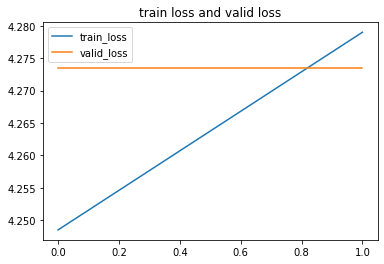

In [19]:
plt.plot(train_losses,label='train_loss')
plt.plot(valid_losses,label='valid_loss')
plt.legend()
plt.title("train loss and valid loss")
plt.show()

# 모델 평가

In [27]:
test_loss=0
for (test_x,test_y) in  tqdm.tqdm((test_loader)):
    with torch.no_grad():
        model.eval()
        test_x=test_x.to(device)
        test_y=test_y.to(device)
        pred=model(test_x)
        loss = cost(pred,test_y)
    test_loss+=loss.item()    
print(f'test Loss: {train_loss/len(train_dataset)}')

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([23, 3, 224, 224]) torch.Size([23, 2])


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

test Loss: 4.278997421264648


In [33]:
it = iter(train_loader)
first = next(it)

ValueError: too many values to unpack (expected 3)

In [35]:
for test_x,test_y in  tqdm.tqdm(test_loader):
    with torch.no_grad():
        for i in range(test_x.shape[0]):
            model.eval()
            test_x=test_x.to(device)[i]
            test_y=test_y.to(device)[i]
            pred=model(test_x)
            print(pred.shape)
            loss = cost(pred,test_y)
            break
    test_loss+=loss.item()    
print(f'test Loss: {train_loss/len(train_dataset)}')

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: expected 4D input (got 3D input)

#CREloss function 

In [18]:
import torch
import torch.nn as nn
import numpy as np
output = [0.8982, 0.805, 0.6393, 0.9983, 0.5731, 0.0469, 0.556, 0.1476, 0.8404, 0.5544]
target = [1]
loss = np.log(sum(np.exp(output))) - output[target[0]]
print(loss) # 2.143818427948945

2.143818427948945


In [19]:
output = torch.Tensor([[0.8982, 0.805, 0.6393, 0.9983, 0.5731, 0.0469, 0.556, 0.1476, 0.8404, 0.5544]])
target = torch.LongTensor([1])
criterion = nn.CrossEntropyLoss()
loss = criterion(output, target)
print(loss) # tensor(2.1438)

tensor(2.1438)


In [20]:
output = [0.8982, 0.805, 0.6393, 0.9983, 0.5731, 0.0469, 0.556, 0.1476, 0.8404, 0.5544]
target = [0,1,0,0,0,0,0,0,0,0]
print(len(target))
loss=0
loss=(-1)*np.sum(np.log(np.exp(output) / np.sum(np.exp(output)))*target)
print(loss) # 2.143818427948945

10
2.143818427948945
